In [1]:
import pandas as pd
import xgboost
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
from math import sqrt

In [2]:
# Read in dataset
nvidia_data = pd.read_csv('stock_news_reddit_df.csv')
nvidia_data.head()

,Date,Close,Return,Log_Return,MA_7,Volatility,ticker_sentiment_score,avg_1d,avg_3d,avg_5d,...,avg_1d_reddit,avg_3d_reddit,avg_5d_reddit,avg_7d_reddit,avg_10d_reddit,avg_1d_reddit_sentiment,avg_3d_reddit_sentiment,avg_5d_reddit_sentiment,avg_7d_reddit_sentiment,avg_10d_reddit_sentiment
0,2024-11-15,141.970215,-0.032570,-0.033112,146.428478,4.108615,0.346622,0.346622,0.330836,0.290071,...,0.9991,0.990667,0.64070,0.712400,0.67765,Positive,Positive,Positive,Positive,Positive
1,2024-11-15,141.970215,-0.032570,-0.033112,146.428478,4.108615,0.346622,0.346622,0.330836,0.290071,...,-0.3544,0.548033,0.72140,0.530114,0.59380,Negative,Positive,Positive,Positive,Positive
2,2024-11-15,141.970215,-0.032570,-0.033112,146.428478,4.108615,0.346622,0.346622,0.330836,0.290071,...,0.9333,0.526000,0.71018,0.540343,0.62362,Positive,Positive,Positive,Positive,Positive
3,2024-11-15,141.970215,-0.032570,-0.033112,146.428478,4.108615,0.346622,0.346622,0.330836,0.290071,...,0.7566,0.445167,0.66680,0.756700,0.63223,Positive,Positive,Positive,Positive,Positive
4,2024-11-18,140.140335,-0.012889,-0.012973,145.181418,3.273268,0.303204,0.303204,0.310892,0.318424,...,0.4394,0.346000,0.55750,0.480914,0.63384,Positive,Positive,Positive,Positive,Positive


In [3]:
# Split into training and test data
print(len(nvidia_data))
# Training: November - First weeks of January
train_data = nvidia_data[(nvidia_data['Date'] >= '2024-11-01') & (nvidia_data['Date'] <= '2025-01-25')]
print(len(train_data))
# Test: Last week of January
test_data = nvidia_data[(nvidia_data['Date'] >= '2025-01-26') & (nvidia_data['Date'] <= '2025-01-31')]
print(len(test_data))

340
252
88


In [4]:
train_data.columns

Index(['Date', 'Close', 'Return', 'Log_Return', 'MA_7', 'Volatility',
       'ticker_sentiment_score', 'avg_1d', 'avg_3d', 'avg_5d', 'avg_7d',
       'avg_10d', 'avg_1d_reddit', 'avg_3d_reddit', 'avg_5d_reddit',
       'avg_7d_reddit', 'avg_10d_reddit', 'avg_1d_reddit_sentiment',
       'avg_3d_reddit_sentiment', 'avg_5d_reddit_sentiment',
       'avg_7d_reddit_sentiment', 'avg_10d_reddit_sentiment'],
      dtype='object')

In [5]:
# Split into features and labels
# Get dummy variables for sentiment
train_data = pd.get_dummies(train_data, columns = ['avg_1d_reddit_sentiment'], drop_first=True)
test_data = pd.get_dummies(test_data, columns = ['avg_1d_reddit_sentiment'], drop_first=True)
train_data.columns

Index(['Date', 'Close', 'Return', 'Log_Return', 'MA_7', 'Volatility',
       'ticker_sentiment_score', 'avg_1d', 'avg_3d', 'avg_5d', 'avg_7d',
       'avg_10d', 'avg_1d_reddit', 'avg_3d_reddit', 'avg_5d_reddit',
       'avg_7d_reddit', 'avg_10d_reddit', 'avg_3d_reddit_sentiment',
       'avg_5d_reddit_sentiment', 'avg_7d_reddit_sentiment',
       'avg_10d_reddit_sentiment', 'avg_1d_reddit_sentiment_Neutral',
       'avg_1d_reddit_sentiment_Positive'],
      dtype='object')

In [6]:
train_features = train_data[['MA_7', 'Volatility','ticker_sentiment_score',
                       'avg_1d', 'avg_1d_reddit', 'avg_1d_reddit_sentiment_Neutral', 'avg_1d_reddit_sentiment_Positive']]

train_labels = train_data['Close']

test_features = test_data[['MA_7', 'Volatility','ticker_sentiment_score',
                       'avg_1d', 'avg_1d_reddit', 'avg_1d_reddit_sentiment_Neutral', 'avg_1d_reddit_sentiment_Positive']]

test_labels = test_data['Close']

In [10]:
# Set features
PERCENTAGE_OF_FEATURES_USED = 1
LEARNING_RATE = 0.01
MAX_DEPTH = 10 # 6 8
NUMBER_OF_BOOSTING_ROUNDS = 100000

In [11]:
# Create model
model = xgboost.XGBRegressor(colsample_bytree = PERCENTAGE_OF_FEATURES_USED,
                             learning_rate = LEARNING_RATE,
                             max_depth = MAX_DEPTH,
                             n_estimators = NUMBER_OF_BOOSTING_ROUNDS)

In [12]:
# Fit model
model.fit(train_features, train_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=100000, n_jobs=None, num_parallel_tree=None,
             random_state=None, ...)

In [13]:
# Get predictions
prediction = model.predict(test_features)

In [14]:
# Calculate accuracy
r2xgb = r2_score(test_labels, prediction)
print(f'The R squared of the xgboost method is: {r2xgb:.2f}')

mae = mean_absolute_error(test_labels, prediction)
print(f'The Mean Absolute Error (MAE) of the xgboost method is: {mae:.2f}')

rmse = sqrt(mean_squared_error(test_labels, prediction))
print(f'The Root Mean Squared Error (RMSE) of the xgboost method is: {rmse:.2f}')

The R squared of the xgboost method is: -12.39
The Mean Absolute Error (MAE) of the xgboost method is: 14.54
The Root Mean Squared Error (RMSE) of the xgboost method is: 15.21


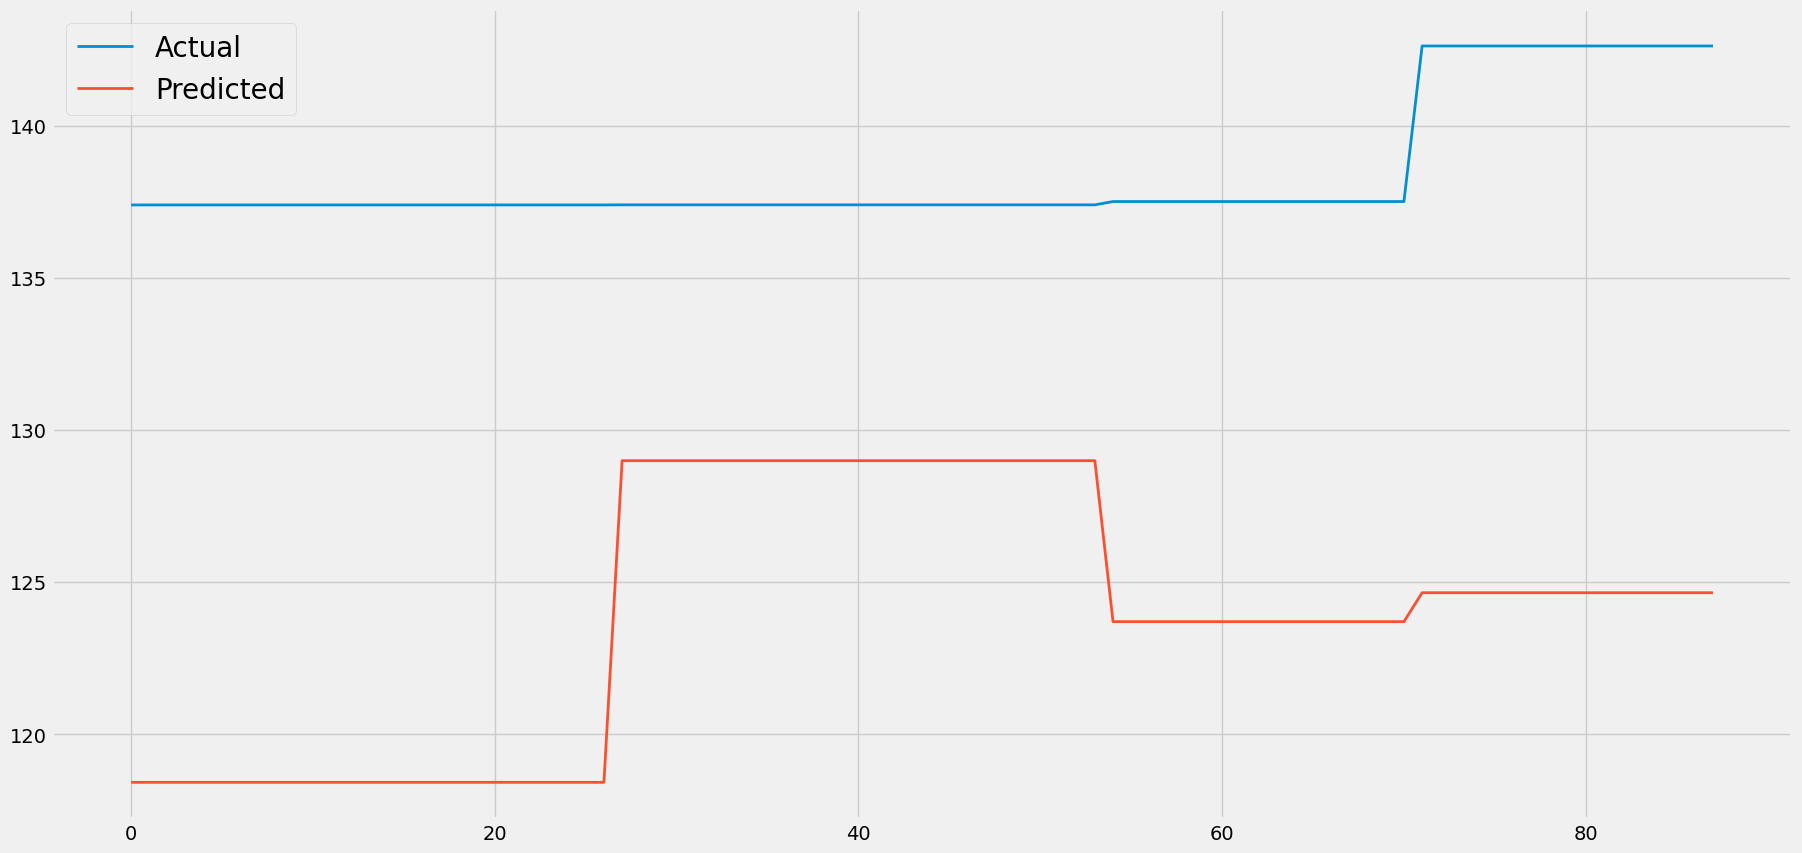

In [15]:
# Plot accuracy
import matplotlib.pyplot as plt
grp = pd.DataFrame({'prediction': prediction,'Actual': test_labels})
grp = grp.reset_index()
grp = grp.drop(['index'],axis=1)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.plot(grp[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})